In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Taking results of [VM-598](https://linear.app/fluence/issue/VM-598/research-standalone-batching-syscall-performance), approximate
RandomX cache init time as second degree polynomial of `k` - number of parallel RandomX invoked.

In [2]:
rx_threads_number = [1, 4, 16]
rx_init_ms = [400, 550, 1200]

In [3]:
init_time = np.polynomial.Polynomial.fit(rx_threads_number, rx_init_ms, deg=2, domain=[1, 64])
# init_time = np.polynomial.Polynomial(coef=[670], domain=[1, 64])

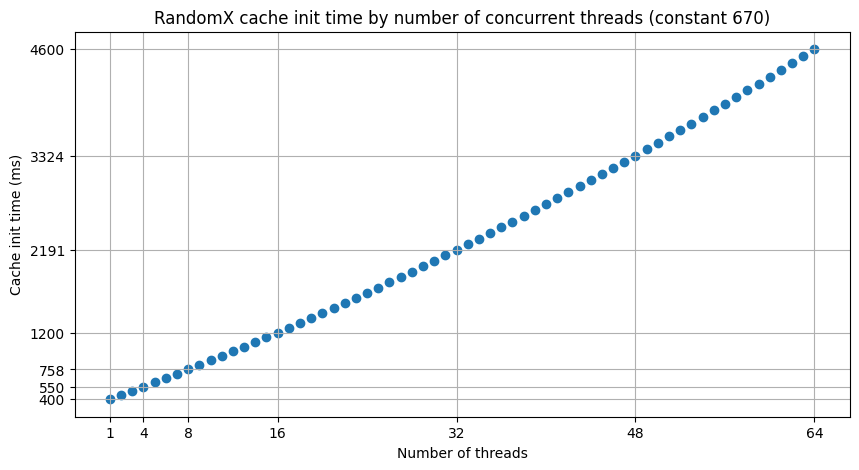

In [4]:
x, y = init_time.linspace(64)

xticks = np.array([1, 4, 8, 16, 32, 48, 64])

plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xticks(xticks)
plt.xlabel("Number of threads")
plt.yticks(init_time(xticks))
plt.ylabel("Cache init time (ms)")
#plt.title("RandomX cache init time by number of concurrent threads (approximation with Quadratic Regression)")
plt.title("RandomX cache init time by number of concurrent threads (constant 670)")
plt.grid(True)

Assuming check time of single proof is constant `c`, define transaction time (in ms) for batch size `n` with `k` compute units in batch
as $t(n, k) = init\_time(k) + \left\lceil \dfrac{n}{k} \right\rceil \cdot c$. Then theoretical limit of PPS (proofs per second) is $\dfrac{n}{t(n, k)} \cdot 1000$.

In [5]:
def PPS(n, k):
    CHECK_TIME = 48 # 48 ms per check
    t = init_time(k) + np.ceil(n / k) * CHECK_TIME
    return 1000 * n / t

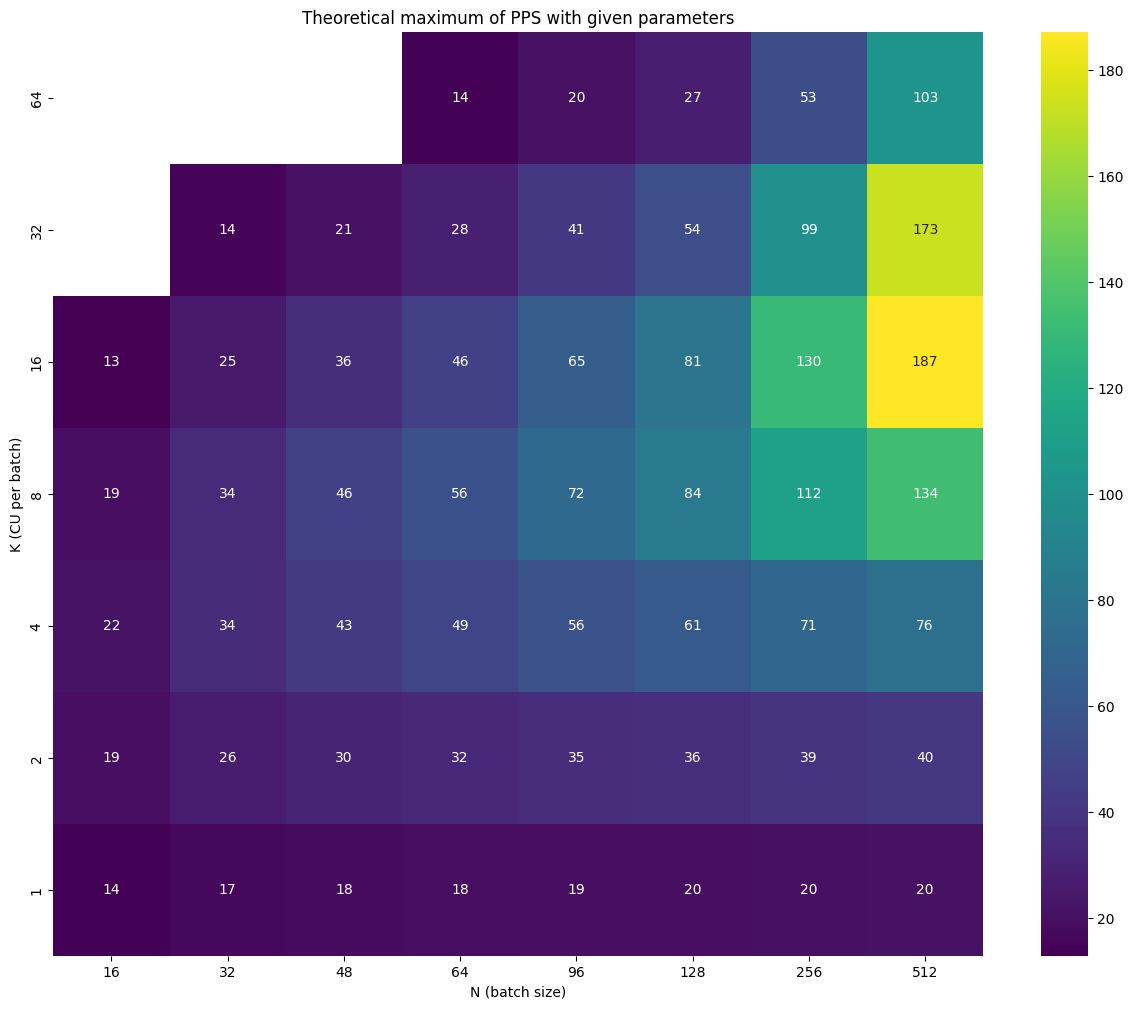

In [6]:
n = np.array([16, 32, 48, 64, 96, 128, 256, 512])
k = np.array([1, 2, 4, 8, 16, 32, 64])
N, K = np.meshgrid(n, k)

P = PPS(N, K)
mask = N < K

plt.figure(figsize=(15, 12))
sns.heatmap(P[::-1], mask=mask[::-1], cmap='viridis', xticklabels=n, yticklabels=k[::-1], annot=True, fmt='.0f')
plt.xlabel('N (batch size)')
plt.ylabel('K (CU per batch)')
plt.title('Theoretical maximum of PPS with given parameters')
plt.show()